In [43]:
!pip install -q ultralytics tqdm lxml matplotlib albumentations torchvision

import os
import shutil
import xml.etree.ElementTree as ET
from tqdm import tqdm
from PIL import Image
import torchvision
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch


In [44]:
class Config:
    VOC_YEAR = "2012"
    VOC_ROOT = "./VOCdevkit/VOC2012"
    OUTPUT_ROOT = "./dataset"
    MODEL_TYPE = "yolov8n.pt"
    CLASSES = [
        'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',
        'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',
        'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'
    ]

Config.TRAINING_CONFIG = Config.TRAINING_CONFIG = {
    'data': "voc.yaml",
    'batch': 32,
    'imgsz': 640,
    'lr0': 0.001,
    'lrf': 0.02,
    'optimizer': "SGD",
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'epochs': 150,
    'augment': True,
    'verbose': True,
    'workers': 4,
    'patience': 300,
    'save': True
}



In [45]:
def prepare_dataset():
    torchvision.datasets.VOCDetection(root=".", year=Config.VOC_YEAR, image_set="train", download=True)
    for dir_path in [f"{Config.OUTPUT_ROOT}/images/train", f"{Config.OUTPUT_ROOT}/images/val",
                     f"{Config.OUTPUT_ROOT}/labels/train", f"{Config.OUTPUT_ROOT}/labels/val"]:
        os.makedirs(dir_path, exist_ok=True)

prepare_dataset()


In [46]:
def convert_annotation(xml_path, txt_path, img_size):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    with open(txt_path, 'w') as f:
        for obj in root.findall('object'):
            cls_name = obj.find('name').text
            if cls_name not in Config.CLASSES:
                continue
            cls_id = Config.CLASSES.index(cls_name)
            bbox = obj.find('bndbox')
            coords = [int(bbox.find(dim).text) for dim in ['xmin', 'ymin', 'xmax', 'ymax']]
            x_center = (coords[0] + coords[2]) / 2 / img_size[0]
            y_center = (coords[1] + coords[3]) / 2 / img_size[1]
            width = (coords[2] - coords[0]) / img_size[0]
            height = (coords[3] - coords[1]) / img_size[1]
            f.write(f"{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")


In [47]:
from tqdm import tqdm
def process_data_split(split_name, limit=None):
    split_file = os.path.join(Config.VOC_ROOT, 'ImageSets/Main', f'{split_name}.txt')
    with open(split_file, 'r') as f:
        image_ids = [line.strip() for line in f.readlines()]
    if limit:
        image_ids = image_ids[:limit]
    for img_id in tqdm(image_ids, desc=f"Processing {split_name}"):
        img_src = os.path.join(Config.VOC_ROOT, 'JPEGImages', f'{img_id}.jpg')
        xml_src = os.path.join(Config.VOC_ROOT, 'Annotations', f'{img_id}.xml')
        img_dest = os.path.join(Config.OUTPUT_ROOT, f'images/{split_name}', f'{img_id}.jpg')
        label_dest = os.path.join(Config.OUTPUT_ROOT, f'labels/{split_name}', f'{img_id}.txt')
        shutil.copy(img_src, img_dest)
        with Image.open(img_src) as img:
            convert_annotation(xml_src, label_dest, img.size)

process_data_split("train", limit=500)
process_data_split("val", limit=100)


Processing val: 100%|██████████| 100/100 [00:00<00:00, 484.93it/s]


In [48]:
def create_yaml_config():
    yaml_content = f"""\
path: {Config.OUTPUT_ROOT}
train: images/train
val: images/val
names: {dict(enumerate(Config.CLASSES))}
"""
    with open("voc.yaml", "w") as f:
        f.write(yaml_content)

create_yaml_config()


In [49]:
def train_model():
    model = YOLO(Config.MODEL_TYPE)
    device = 0 if torch.cuda.is_available() else 'cpu'
    print(f"Training on device: {device}")
    Config.TRAINING_CONFIG['device'] = device
    results = model.train(**Config.TRAINING_CONFIG)
    return results

results = train_model()


Training on device: 0
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=voc.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.02, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train5, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, patience=300, perspective=0.0, plots=True, pose=12.0, pretrained

train: Scanning /content/dataset/labels/train.cache... 500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 500/500 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 499.6±129.3 MB/s, size: 87.4 KB)


val: Scanning /content/dataset/labels/val.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]


Plotting labels to runs/detect/train5/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train5
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150      4.29G     0.9542      4.055      1.203        118        640: 100%|██████████| 16/16 [00:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]

                   all        100        239   0.000308     0.0402    0.00897    0.00649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      4.54G     0.9451      3.755      1.212        104        640: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all        100        239   0.000281     0.0387     0.0225     0.0165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      4.54G     0.9448      3.449      1.203        123        640: 100%|██████████| 16/16 [00:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all        100        239    0.00232     0.0516     0.0354     0.0257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      4.54G     0.9515      3.104        1.2        122        640: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all        100        239      0.794     0.0268     0.0502     0.0377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      4.54G     0.9095       2.92      1.203         98        640: 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all        100        239      0.944     0.0335     0.0855     0.0622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      4.54G     0.9098      2.758      1.187        150        640: 100%|██████████| 16/16 [00:08<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all        100        239      0.996     0.0361      0.113      0.086



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      4.54G     0.9155      2.547       1.18        127        640: 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all        100        239      0.995     0.0418      0.157      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      4.54G     0.9035      2.503      1.176        117        640: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all        100        239      0.854     0.0907      0.229      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      4.54G     0.8933      2.364      1.169        132        640: 100%|██████████| 16/16 [00:07<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all        100        239      0.762      0.178      0.327      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      4.54G     0.8948      2.248      1.188         95        640: 100%|██████████| 16/16 [00:07<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        100        239      0.745      0.257      0.374      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      4.55G     0.9031      2.112      1.192        143        640: 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]

                   all        100        239      0.786      0.272      0.385      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      4.56G     0.8913      1.967      1.179        157        640: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all        100        239      0.669      0.363      0.429      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      4.57G     0.8953      1.941      1.162        151        640: 100%|██████████| 16/16 [00:07<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all        100        239      0.658      0.363      0.447      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150      4.57G     0.8751      1.858      1.155        141        640: 100%|██████████| 16/16 [00:07<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all        100        239      0.755      0.339      0.421      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      4.57G      0.883      1.764      1.165        133        640: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all        100        239      0.727      0.367      0.467      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      4.57G     0.8569      1.736       1.17        126        640: 100%|██████████| 16/16 [00:07<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all        100        239      0.796      0.348      0.485      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      4.57G     0.8685      1.669      1.144        144        640: 100%|██████████| 16/16 [00:07<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all        100        239      0.694      0.394      0.504      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      4.57G     0.8697       1.58      1.147        130        640: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]

                   all        100        239      0.667      0.403      0.507      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      4.57G     0.8532       1.63      1.171        109        640: 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all        100        239      0.614      0.541      0.554      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150      4.57G     0.8343      1.557      1.132         98        640: 100%|██████████| 16/16 [00:07<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all        100        239      0.685      0.502      0.569      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      4.57G     0.8483      1.533      1.139        122        640: 100%|██████████| 16/16 [00:07<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all        100        239      0.686       0.51       0.59      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      4.57G     0.8339      1.507      1.138        118        640: 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all        100        239       0.74      0.522      0.602      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      4.57G      0.826      1.454      1.126        105        640: 100%|██████████| 16/16 [00:07<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all        100        239      0.738      0.509      0.621      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      4.57G     0.8296      1.433      1.136        115        640: 100%|██████████| 16/16 [00:07<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all        100        239      0.651      0.566      0.626      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      4.57G     0.7985      1.371       1.12        144        640: 100%|██████████| 16/16 [00:07<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]

                   all        100        239      0.649      0.574      0.629      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150      4.57G     0.8077      1.395      1.113        122        640: 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all        100        239      0.644      0.571      0.592      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      4.57G     0.7934      1.371      1.116        123        640: 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all        100        239      0.767      0.455      0.575      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150      4.57G     0.7705      1.347      1.112        114        640: 100%|██████████| 16/16 [00:08<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all        100        239      0.753      0.526      0.606      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      4.57G     0.8058      1.389      1.116        142        640: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        100        239      0.666      0.585      0.597      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      4.57G     0.7847      1.352      1.096        140        640: 100%|██████████| 16/16 [00:07<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all        100        239      0.604      0.578      0.594      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      4.57G     0.7754      1.329      1.106        126        640: 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all        100        239      0.747       0.53      0.611      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      4.57G     0.7744      1.325      1.103        106        640: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]

                   all        100        239       0.73      0.535      0.616      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      4.57G     0.7665       1.27      1.098        138        640: 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all        100        239      0.791      0.527      0.631      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      4.57G     0.7955      1.284      1.106        135        640: 100%|██████████| 16/16 [00:07<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all        100        239      0.724      0.547      0.631      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      4.57G     0.7654      1.285      1.091        129        640: 100%|██████████| 16/16 [00:07<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all        100        239       0.71      0.568      0.642      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      4.58G     0.7603      1.273      1.085        125        640: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all        100        239      0.775      0.575      0.652      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      4.58G     0.7604      1.283      1.088         75        640: 100%|██████████| 16/16 [00:07<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all        100        239      0.791      0.547      0.652      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      4.59G     0.7662      1.236       1.09        139        640: 100%|██████████| 16/16 [00:07<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all        100        239      0.695      0.582      0.647      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      4.59G     0.7605      1.234      1.081        145        640: 100%|██████████| 16/16 [00:06<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]

                   all        100        239      0.689      0.558      0.638      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      4.59G     0.7685       1.21      1.093        108        640: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all        100        239      0.725       0.53      0.629      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      4.59G     0.7648       1.23      1.087        139        640: 100%|██████████| 16/16 [00:07<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all        100        239      0.662      0.605      0.632      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150      4.59G     0.7515       1.19      1.077        133        640: 100%|██████████| 16/16 [00:07<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all        100        239      0.674      0.528      0.596       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150      4.59G      0.732       1.21      1.068        132        640: 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all        100        239      0.662      0.515      0.605      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      4.59G     0.7524      1.202      1.064        137        640: 100%|██████████| 16/16 [00:07<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all        100        239      0.741       0.46      0.615      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      4.59G     0.7386      1.196      1.085        110        640: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all        100        239      0.544      0.631      0.639       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      4.59G     0.7541      1.183      1.094        113        640: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]

                   all        100        239      0.718      0.575      0.667      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      4.59G     0.7533      1.191       1.08        125        640: 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all        100        239      0.748      0.548      0.668      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      4.59G     0.7309      1.137       1.06        135        640: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all        100        239      0.567       0.64      0.657      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      4.59G     0.7279      1.124       1.07        122        640: 100%|██████████| 16/16 [00:06<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all        100        239       0.76      0.504      0.649      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150      4.59G      0.712      1.141      1.068        121        640: 100%|██████████| 16/16 [00:07<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all        100        239      0.627      0.622       0.66       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      4.59G     0.7196      1.119      1.065        107        640: 100%|██████████| 16/16 [00:09<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all        100        239      0.616      0.621      0.645      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      4.59G     0.7156      1.112      1.068        119        640: 100%|██████████| 16/16 [00:07<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all        100        239      0.666      0.556      0.659      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      4.59G     0.7189      1.126      1.063        134        640: 100%|██████████| 16/16 [00:08<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all        100        239      0.661      0.616      0.666      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      4.59G     0.7082      1.132      1.062        138        640: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all        100        239       0.69      0.622      0.667      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      4.59G      0.735      1.109       1.06        113        640: 100%|██████████| 16/16 [00:07<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all        100        239      0.667      0.655      0.675      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      4.59G     0.7013      1.097      1.066        133        640: 100%|██████████| 16/16 [00:07<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        100        239      0.648      0.647      0.658      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      4.59G      0.699       1.08      1.055        118        640: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


                   all        100        239      0.701      0.634      0.673      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      4.59G     0.7004      1.087      1.056        110        640: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all        100        239      0.723      0.622      0.667      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      4.59G     0.7054      1.084      1.058        128        640: 100%|██████████| 16/16 [00:07<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.00it/s]

                   all        100        239      0.707      0.629      0.676      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      4.59G     0.7392      1.119      1.065        120        640: 100%|██████████| 16/16 [00:08<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all        100        239      0.668      0.635      0.658      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      4.59G     0.6883      1.063      1.041        146        640: 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.16it/s]

                   all        100        239      0.721      0.666      0.674      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      4.59G      0.712      1.094      1.058        130        640: 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all        100        239      0.636      0.661       0.67      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      4.59G     0.7009      1.065      1.048        151        640: 100%|██████████| 16/16 [00:07<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all        100        239      0.661      0.649      0.684      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      4.59G     0.6896      1.059      1.041        105        640: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

                   all        100        239      0.645      0.688        0.7      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      4.59G     0.6643      1.069      1.037        103        640: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all        100        239      0.739      0.577      0.673      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      4.59G     0.7081      1.076      1.055        131        640: 100%|██████████| 16/16 [00:07<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all        100        239      0.645      0.626      0.669      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      4.59G     0.6925      1.052       1.04        121        640: 100%|██████████| 16/16 [00:07<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all        100        239      0.678      0.617       0.64       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      4.59G      0.682      1.049      1.039        110        640: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all        100        239      0.687      0.612      0.638      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      4.59G     0.6842      1.047       1.03        103        640: 100%|██████████| 16/16 [00:07<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all        100        239      0.746       0.57      0.634      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150      4.59G     0.6676      1.012      1.027        122        640: 100%|██████████| 16/16 [00:07<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all        100        239      0.674      0.618      0.652      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      4.59G     0.7017      1.045      1.048        133        640: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]

                   all        100        239      0.685      0.628      0.656      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      4.59G     0.6674      1.049      1.035        126        640: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all        100        239      0.699      0.659       0.66       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      4.59G     0.6669      1.038      1.034        136        640: 100%|██████████| 16/16 [00:07<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all        100        239      0.694      0.653      0.665       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      4.59G      0.698      1.029      1.041        147        640: 100%|██████████| 16/16 [00:06<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]

                   all        100        239      0.674      0.634      0.661      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      4.59G     0.6642      1.009      1.029        128        640: 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all        100        239      0.677      0.608       0.67      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      4.59G      0.671      1.013      1.035        137        640: 100%|██████████| 16/16 [00:07<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all        100        239      0.754      0.617      0.685      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      4.59G       0.66      1.022      1.029        105        640: 100%|██████████| 16/16 [00:07<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all        100        239      0.755      0.606      0.636      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      4.59G     0.6737      1.018      1.022        133        640: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

                   all        100        239      0.721      0.601      0.655      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150      4.59G     0.6792      1.021       1.04        139        640: 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all        100        239      0.709      0.625      0.638       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      4.59G     0.6672      1.006      1.032        102        640: 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all        100        239      0.673      0.617      0.632      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150       4.6G     0.6482      1.005      1.028        113        640: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]

                   all        100        239      0.678      0.608      0.641      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150       4.6G     0.6562     0.9918      1.031        156        640: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all        100        239      0.699      0.601      0.636      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150       4.6G     0.6564     0.9927      1.025        119        640: 100%|██████████| 16/16 [00:07<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all        100        239      0.702        0.6      0.634      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150       4.6G     0.6483      1.025      1.034        122        640: 100%|██████████| 16/16 [00:07<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all        100        239      0.754      0.581      0.646      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150       4.6G     0.6628     0.9928      1.028        126        640: 100%|██████████| 16/16 [00:06<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all        100        239      0.715      0.598      0.656      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150       4.6G      0.633      0.967      1.019        125        640: 100%|██████████| 16/16 [00:07<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all        100        239       0.74      0.615      0.649       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150       4.6G      0.637     0.9866      1.017        123        640: 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all        100        239       0.73      0.625      0.651      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150       4.6G     0.6586     0.9931      1.035        108        640: 100%|██████████| 16/16 [00:06<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

                   all        100        239      0.769      0.615       0.66      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150       4.6G     0.6383     0.9681      1.021        141        640: 100%|██████████| 16/16 [00:07<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all        100        239      0.686      0.624       0.66      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150       4.6G     0.6341     0.9732      1.027        121        640: 100%|██████████| 16/16 [00:07<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all        100        239      0.728      0.619      0.686      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150       4.6G     0.6446     0.9797      1.028        123        640: 100%|██████████| 16/16 [00:07<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]

                   all        100        239      0.727      0.617      0.685      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150       4.6G     0.6488     0.9711      1.016        123        640: 100%|██████████| 16/16 [00:06<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all        100        239      0.737      0.611      0.692      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150       4.6G     0.6391     0.9808      1.027        126        640: 100%|██████████| 16/16 [00:07<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all        100        239      0.716      0.631      0.688      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150       4.6G     0.6451     0.9734      1.024        133        640: 100%|██████████| 16/16 [00:07<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all        100        239      0.696      0.639      0.681      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150       4.6G      0.656     0.9693      1.034        127        640: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all        100        239      0.604       0.66       0.67      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150       4.6G     0.6581     0.9323      1.008        137        640: 100%|██████████| 16/16 [00:07<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        100        239      0.689      0.585      0.663      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150       4.6G     0.6516     0.9526      1.019        150        640: 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all        100        239      0.707      0.609      0.656      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150       4.6G      0.628     0.9361      1.007        124        640: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]

                   all        100        239      0.752      0.594      0.656      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150       4.6G     0.6314     0.9374      1.009        146        640: 100%|██████████| 16/16 [00:07<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all        100        239      0.808      0.561      0.663      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150       4.6G      0.645      0.945      1.022        120        640: 100%|██████████| 16/16 [00:07<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all        100        239      0.767      0.581      0.665      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150       4.6G     0.6088      0.932      1.007         98        640: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.04it/s]

                   all        100        239      0.699      0.632      0.665      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150       4.6G      0.642     0.9674      1.022        132        640: 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all        100        239      0.754      0.615      0.672       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150       4.6G      0.629      0.931      1.001        146        640: 100%|██████████| 16/16 [00:07<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all        100        239      0.784      0.602      0.674      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150       4.6G     0.6217     0.9238      1.017        155        640: 100%|██████████| 16/16 [00:07<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all        100        239      0.715      0.633      0.668      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150       4.6G     0.6223     0.9386       1.01        112        640: 100%|██████████| 16/16 [00:06<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all        100        239      0.701      0.625      0.672      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150       4.6G     0.6087     0.9549      1.006        123        640: 100%|██████████| 16/16 [00:07<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all        100        239      0.743      0.587      0.664      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150       4.6G     0.6337     0.9459      1.022        106        640: 100%|██████████| 16/16 [00:07<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all        100        239      0.759      0.585       0.67      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150       4.6G     0.6274      0.958      1.017        164        640: 100%|██████████| 16/16 [00:06<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.11it/s]

                   all        100        239      0.767      0.601      0.663      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150       4.6G     0.6251     0.9439       1.01        125        640: 100%|██████████| 16/16 [00:06<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all        100        239      0.743      0.582      0.659      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150       4.6G     0.6167     0.9227      1.014        128        640: 100%|██████████| 16/16 [00:07<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all        100        239      0.688      0.637      0.658      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150       4.6G     0.6031     0.9319      1.005        119        640: 100%|██████████| 16/16 [00:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.12s/it]

                   all        100        239      0.734      0.574      0.655      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150       4.6G     0.6309     0.9492       1.01        129        640: 100%|██████████| 16/16 [00:06<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all        100        239      0.665      0.623      0.675      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150       4.6G     0.6259     0.9245      1.014        118        640: 100%|██████████| 16/16 [00:07<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all        100        239      0.743        0.6      0.661      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150       4.6G     0.6291     0.9393      1.007         92        640: 100%|██████████| 16/16 [00:07<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all        100        239      0.728      0.597      0.659      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150       4.6G     0.6127     0.9343      1.009        133        640: 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all        100        239       0.73       0.61       0.66      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150       4.6G     0.6175     0.9571      1.016        121        640: 100%|██████████| 16/16 [00:07<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all        100        239      0.735      0.607      0.651      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150       4.6G     0.6004     0.9168     0.9973        117        640: 100%|██████████| 16/16 [00:07<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all        100        239      0.694      0.643       0.68       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150       4.6G     0.6105     0.9493      1.016        122        640: 100%|██████████| 16/16 [00:06<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.07it/s]

                   all        100        239      0.731      0.626       0.68      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150       4.6G     0.6066     0.8967     0.9902        109        640: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all        100        239      0.732      0.626      0.674      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150       4.6G     0.6081     0.9468      1.013        131        640: 100%|██████████| 16/16 [00:07<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all        100        239      0.744       0.62      0.667      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150       4.6G     0.6067     0.8996     0.9972        139        640: 100%|██████████| 16/16 [00:07<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all        100        239      0.741      0.618      0.686        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150       4.6G     0.6054     0.9114      1.004        111        640: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all        100        239      0.806      0.577      0.677      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150       4.6G     0.6116      0.937      1.015        125        640: 100%|██████████| 16/16 [00:08<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all        100        239       0.79      0.592      0.669      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150       4.6G      0.603      0.901      1.003        128        640: 100%|██████████| 16/16 [00:07<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all        100        239      0.779       0.59      0.659       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150       4.6G     0.6161     0.9322      1.011        116        640: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all        100        239      0.784      0.586       0.67      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150       4.6G      0.587     0.9025     0.9904        126        640: 100%|██████████| 16/16 [00:07<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all        100        239      0.749       0.61      0.669      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150       4.6G     0.6195      0.923      1.001        155        640: 100%|██████████| 16/16 [00:07<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all        100        239       0.78      0.598      0.669      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150       4.6G     0.5938     0.8912     0.9925        118        640: 100%|██████████| 16/16 [00:06<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

                   all        100        239      0.788      0.604      0.673      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150       4.6G      0.605     0.9139      1.005        124        640: 100%|██████████| 16/16 [00:06<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all        100        239      0.805      0.595      0.666      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150       4.6G     0.6077     0.9088      1.001        108        640: 100%|██████████| 16/16 [00:07<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all        100        239      0.758       0.61      0.671      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150       4.6G     0.6004     0.9031      1.007        119        640: 100%|██████████| 16/16 [00:07<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        100        239      0.765      0.608      0.684      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150       4.6G      0.595       0.91     0.9985        120        640: 100%|██████████| 16/16 [00:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all        100        239      0.779      0.615      0.692      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150       4.6G      0.601     0.9006     0.9929        105        640: 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all        100        239       0.71      0.627      0.685        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150       4.6G     0.6081     0.8961     0.9974        128        640: 100%|██████████| 16/16 [00:07<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        100        239      0.725      0.615       0.68      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150       4.6G      0.581      0.893     0.9997        126        640: 100%|██████████| 16/16 [00:06<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]

                   all        100        239      0.745      0.609       0.68      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150       4.6G     0.5966     0.8885     0.9929        126        640: 100%|██████████| 16/16 [00:06<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all        100        239      0.762      0.595      0.674      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150       4.6G     0.5975     0.9081     0.9988        115        640: 100%|██████████| 16/16 [00:07<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all        100        239      0.722       0.62      0.675      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150       4.6G     0.6053     0.8996     0.9983        159        640: 100%|██████████| 16/16 [00:06<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]

                   all        100        239      0.795      0.583       0.68      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150       4.6G     0.5952     0.8947     0.9928        109        640: 100%|██████████| 16/16 [00:06<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all        100        239      0.795      0.587      0.679      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150       4.6G     0.6031     0.9038     0.9972        131        640: 100%|██████████| 16/16 [00:07<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all        100        239      0.779      0.592      0.671      0.491


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150       4.6G     0.6348      1.267     0.9893         46        640: 100%|██████████| 16/16 [00:09<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all        100        239      0.734      0.618      0.659       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150       4.6G     0.6014       1.18     0.9794         68        640: 100%|██████████| 16/16 [00:06<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]

                   all        100        239      0.713      0.595      0.643      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150       4.6G     0.5876      1.159     0.9825         55        640: 100%|██████████| 16/16 [00:06<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all        100        239      0.585      0.666      0.641      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150       4.6G     0.5825      1.115     0.9601         71        640: 100%|██████████| 16/16 [00:07<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all        100        239      0.617      0.607      0.621      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150       4.6G      0.548      1.062     0.9511         67        640: 100%|██████████| 16/16 [00:06<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all        100        239      0.622      0.614       0.62      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150       4.6G     0.5478      1.058     0.9475         52        640: 100%|██████████| 16/16 [00:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all        100        239      0.602      0.634      0.616       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150       4.6G     0.5514      1.073     0.9561         58        640: 100%|██████████| 16/16 [00:07<00:00,  2.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all        100        239      0.614      0.628      0.617      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150       4.6G     0.5465      1.067     0.9588         78        640: 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]

                   all        100        239      0.641       0.63       0.62      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150       4.6G     0.5463      1.044     0.9587         69        640: 100%|██████████| 16/16 [00:06<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all        100        239      0.626      0.607      0.619      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150       4.6G     0.5441       1.05      0.947         62        640: 100%|██████████| 16/16 [00:07<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]

                   all        100        239       0.64      0.594      0.626      0.445



150 epochs completed in 0.385 hours.
Optimizer stripped from runs/detect/train5/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train5/weights/best.pt, 6.3MB

Validating runs/detect/train5/weights/best.pt...
Ultralytics 8.3.145 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,009,548 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


                   all        100        239      0.742      0.558      0.677      0.515
             aeroplane          4          6      0.536        0.5      0.563      0.369
               bicycle          3          4      0.874        0.5      0.825      0.664
                  bird          4          8      0.824      0.589      0.578      0.366
                  boat          5          7      0.459      0.286       0.27      0.167
                bottle          6          9      0.856      0.333       0.49      0.358
                   bus          2          2          1          0      0.663      0.332
                   car         14         24       0.93      0.558      0.786      0.553
                   cat         10         10      0.935        0.8      0.977      0.779
                 chair         10         18      0.446      0.556       0.56      0.361
                   cow          2          3          1      0.496      0.747      0.681
           diningtabl

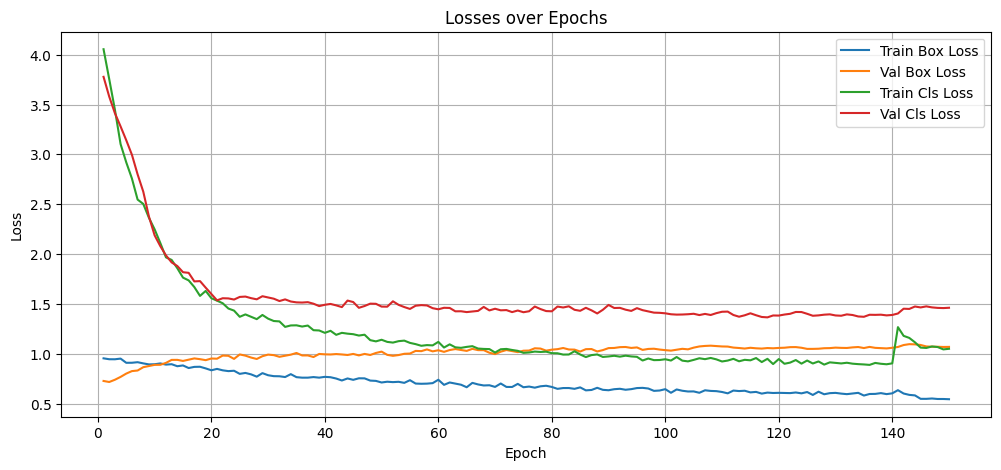

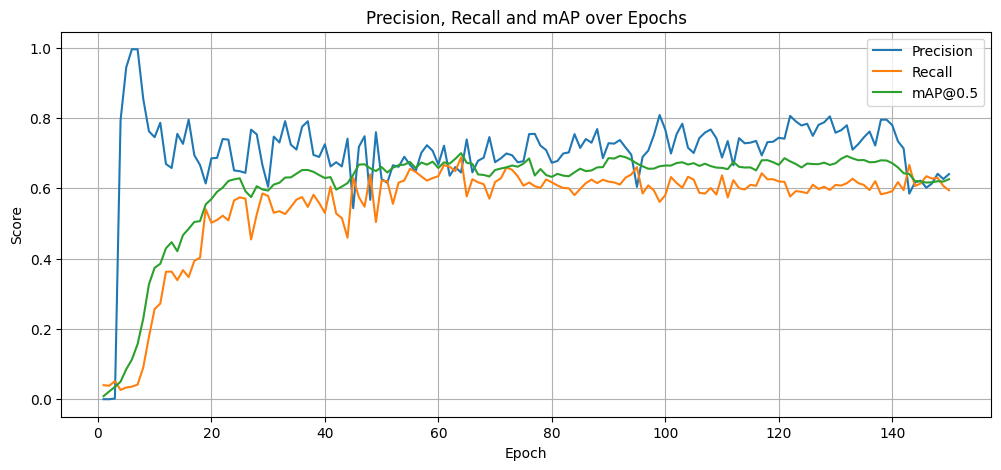

Final Precision: 0.6404
Final Recall: 0.5944
Final mAP50: 0.6260


In [51]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/runs/detect/train5/results.csv')

plt.figure(figsize=(12,5))
plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
plt.plot(df['epoch'], df['train/cls_loss'], label='Train Cls Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Val Cls Loss')
plt.title('Losses over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
plt.title('Precision, Recall and mAP over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()

print(f"Final Precision: {df['metrics/precision(B)'].iloc[-1]:.4f}")
print(f"Final Recall: {df['metrics/recall(B)'].iloc[-1]:.4f}")
print(f"Final mAP50: {df['metrics/mAP50(B)'].iloc[-1]:.4f}")


Saving 2008_000448.jpg to 2008_000448.jpg

image 1/1 /content/2008_000448.jpg: 640x480 2 persons, 38.6ms
Speed: 2.3ms preprocess, 38.6ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 480)


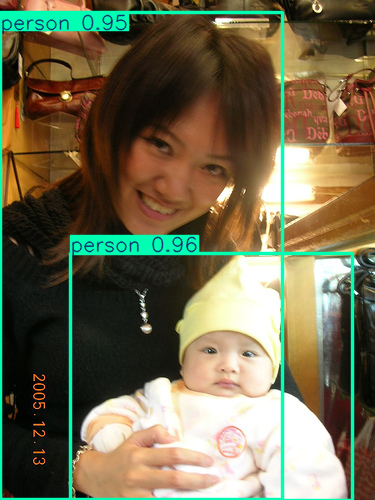

In [38]:
from google.colab import files
uploaded = files.upload()

from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

model = YOLO("/content/runs/detect/train4/weights/best.pt")

image_path = "2008_000448.jpg"

results = model(image_path)

results[0].show()

Saving 2008_001054.jpg to 2008_001054.jpg

image 1/1 /content/2008_001054.jpg: 448x640 1 aeroplane, 3 persons, 39.4ms
Speed: 2.2ms preprocess, 39.4ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


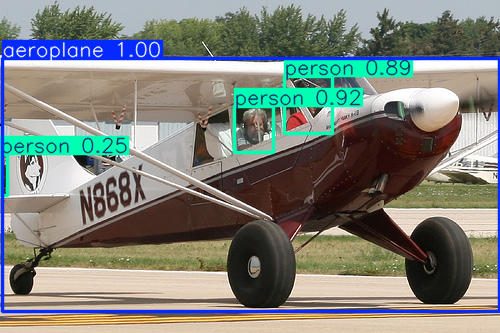

In [39]:
from google.colab import files
uploaded = files.upload()

from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

model = YOLO("/content/runs/detect/train4/weights/best.pt")

image_path = "2008_001054.jpg"

results = model(image_path)

results[0].show()

Saving 2008_001982.jpg to 2008_001982.jpg

image 1/1 /content/2008_001982.jpg: 480x640 2 persons, 66.2ms
Speed: 5.0ms preprocess, 66.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


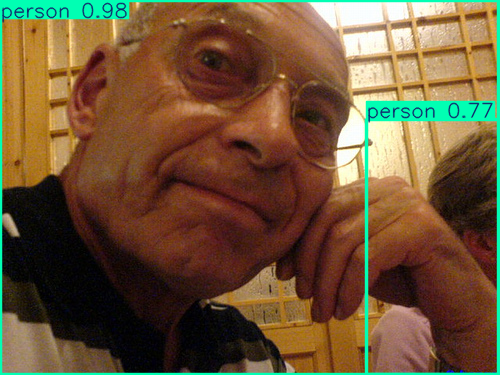

In [40]:
from google.colab import files
uploaded = files.upload()

from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

model = YOLO("/content/runs/detect/train4/weights/best.pt")


image_path = "2008_001982.jpg"

results = model(image_path)

results[0].show()

Saving 2008_000266.jpg to 2008_000266.jpg

image 1/1 /content/2008_000266.jpg: 448x640 6 persons, 10.6ms
Speed: 2.4ms preprocess, 10.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


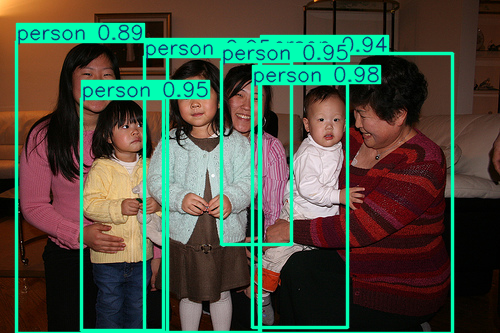

In [41]:
from google.colab import files
uploaded = files.upload()

from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

model = YOLO("/content/runs/detect/train4/weights/best.pt")

image_path = "2008_000266.jpg"

results = model(image_path)

results[0].show()

Saving 2008_000356.jpg to 2008_000356.jpg

image 1/1 /content/2008_000356.jpg: 480x640 1 car, 9.4ms
Speed: 2.6ms preprocess, 9.4ms inference, 5.8ms postprocess per image at shape (1, 3, 480, 640)


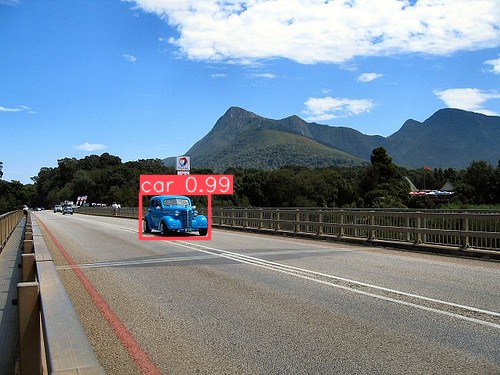

In [42]:
from google.colab import files
uploaded = files.upload()

from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt

model = YOLO("/content/runs/detect/train4/weights/best.pt")


image_path = "2008_000356.jpg"

results = model(image_path)

results[0].show()